Pretrenowanie modelu (XLNet i RoBERTa) przystosowanego do okreslania interpretowalnego podobienstwa semantycznego (iSTS - https://alt.qcri.org/semeval2016/task2/) dwoch zdan w jezyku angielskim. Odniesienie sie do wynikow z obronionej pracy magisterskiej/projektu. 2-3 os.

jezyk implementacji: zalezny od dostepnych rozwiazan (zazwyczaj Python) Zadania:

Zapoznac sie z praca magisterska/projektem i przygotowanym rozwiazaniem. Zapoznac sie z wykorzystywanymi modelami, XLNet https://arxiv.org/pdf/1906.08237.pdf, https://towardsdatascience.com/what-is-xlnet-and-why-it-outperforms-bert-8d8fce710335 , RoBERTa Dokonać dodatkowego wstępnego uczenia modelu ( a. pretraining nienadzorowany, b. na poziomie klasyfikatora/regresji) Zweryfikować w jaki sposób traktowane są typy SPE1, SPE2 oraz noali. Policzyc miary F (F score, F type, F score+type) dla stworzonego systemu dla wszystkich dostepnych danych z SemEval 2015 Interpretable STS z pojedynczymi relacjami oraz SemEval 2016 - Interpretable STS z rozbudowanymi relacjami. Praca magisterska/projekt, dostepny system (z pracy magisterskiej/projektu) i dane dla iSTS.

Ideę dotrenowania można zaczerpnąć z tego artykułu: https://aclanthology.org/2020.coling-industry.6.pdf

Artykuł zawiera też namiary na zbiory parafraz, które można użyć do pretrenowania: Paraphrases, MultiNLI, Quora, Bible.

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")


root = '/content/drive/My Drive/NLP'

Mounted at /content/drive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 31 15:39:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
sts_path = os.path.join(root, 'stsb/')
print(sts_path)

/content/drive/My Drive/Magisterka/SEM 2/NLP/PROJEKT/stsb/


In [ ]:
!pip3 install transformers==4.25.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.8 MB/s eta 0:00:00


# Instalacja bibliotek

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import seaborn as sns
import transformers
import pandas as pd
import seaborn as sns
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from ipywidgets import IntProgress
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
import time

In [ ]:
if torch.cuda.is_available():
    print('Connected to GPU')
else:
    print('Not connected to a GPU')

Connected to GPU


In [ ]:
df_train = pd.read_csv(sts_path+'stsb-en-train.csv', delimiter=',', header=None, names=['s1', 's2', 'target'])
df_valid = pd.read_csv(sts_path+'stsb-en-dev.csv', delimiter=',', header=None, names=['s1', 's2', 'target'])
df_test = pd.read_csv(sts_path+'stsb-en-test.csv', delimiter=',', header=None, names=['s1', 's2', 'target'])

In [ ]:
from decimal import Decimal
# Load CSV file with dataset. Perform basic transformations.
df_train = pd.read_csv(sts_path+'/stsb-en-train.csv', delimiter=',', header= None, names = ['s1','s2','target'])
df_valid = pd.read_csv(sts_path+'/stsb-en-dev.csv', delimiter=',', header= None, names = ['s1','s2','target'])
df_test = pd.read_csv(sts_path+'/stsb-en-test.csv', delimiter=',', header= None, names = ['s1','s2','target'])

def process_sts(df_data):
  df_data['text'] = df_data['s1'] + df_data['s2']
  df_data = df_data[['text', 'target']].copy()
  df_data['target'] = df_data['target'].map(lambda x: int(Decimal(x).to_integral_value()))
  return df_data

df_train = process_sts(df_train)
df_valid = process_sts(df_valid)
df_test = process_sts(df_test)

In [ ]:
num_outputs = df_train['target'].nunique()
print(num_outputs)

6


In [ ]:
df_train = pd.concat([df_train, df_test])

In [ ]:
print(df_train.shape)

(7128, 2)


Inicjalizacja GPU, czyszczenie cache.

In [ ]:
df_train.head(10)

,text,target
0,A plane is taking off.An air plane is taking off.,5
1,A man is playing a large flute.A man is playin...,4
2,A man is spreading shreded cheese on a pizza.A...,4
3,Three men are playing chess.Two men are playin...,3
4,A man is playing the cello.A man seated is pla...,4
5,Some men are fighting.Two men are fighting.,4
6,A man is smoking.A man is skating.,0
7,The man is playing the piano.The man is playin...,2
8,A man is playing on a guitar and singing.A wom...,2
9,A person is throwing a cat on to the ceiling.A...,5


In [ ]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)
import gc
torch.cuda.empty_cache()
gc.collect()

cuda:0


83

Budowanie modelu

In [ ]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
class Data(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [ ]:
MAX_LEN = 256


train_data = df_train.reset_index(drop=True)
valid_data = df_valid.reset_index(drop=True)
test_data = df_test.reset_index(drop=True)

print("TRAIN Dataset: {}".format(train_data.shape))
print("VALID Dataset: {}".format(valid_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = Data(train_data, tokenizer, MAX_LEN)
valid_set = Data(valid_data, tokenizer, MAX_LEN)
testing_set = Data(test_data, tokenizer, MAX_LEN)

TRAIN Dataset: (7128, 2)
VALID Dataset: (1500, 2)
TEST Dataset: (1379, 2)


<Axes: >

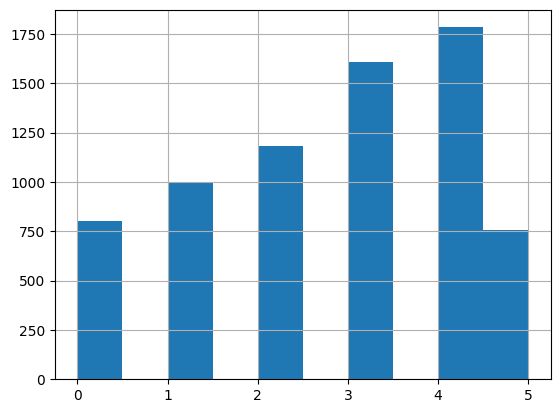

In [ ]:
train_data['target'].hist()

<Axes: >

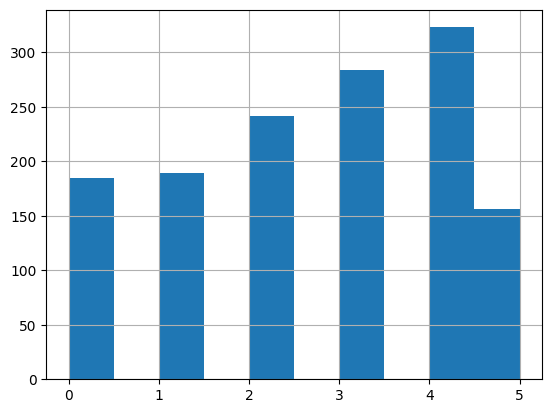

In [ ]:
test_data['target'].hist()

Stosujemy odwrotne wagowanie klas.

In [ ]:
class_value_counts = pd.DataFrame(train_data['target']).value_counts(sort=False)
    # odwrotne wagowanie klas
weights = ((1/class_value_counts.values) / np.sum(1/class_value_counts.values ))
print(weights)
class_weights = torch.FloatTensor(weights).cuda()

[0.2232061  0.17874362 0.15119804 0.1111861  0.10009242 0.23557372]


Metody użyteczne do zapisu metryk

In [ ]:
def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, path)
    

def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

Modele klasyfikujące

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self, roberta_path = None):
        super(RobertaClass, self).__init__()
        if roberta_path:
          self.l1 = torch.load(roberta_path)
        else:
          self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(0.3)
        self.l2 = torch.nn.Linear(64, num_outputs)
 

    def save_roberta(self, path):
        torch.save(self.l1, path)

    def save_model(self, path):
        torch.save(self, path)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = self.bn1(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.d2(pooler)
        output = self.l2(pooler)
        return output

Funkcja do pretriningu

In [ ]:
def pretrain(model, 
             optimizer, 
             training_loader, 
             valid_loader, 
             scheduler = None,
             valid_period = 0,
             num_epochs = 5):
    
    # #Pretrain linear layers, do not train bert
    # for param in model.l1.parameters():
    #     param.requires_grad = False
    
    model.train()
    valid_period = len(training_loader)
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    # Train loop
    for epoch in range(num_epochs):
        for _,data in tqdm(enumerate(training_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids)
            
            loss = torch.nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)
                        
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                valid_loss = 0.0
                with torch.no_grad():
                                        
                    for _,vdata in tqdm(enumerate(valid_loader, 0)):
                        vids = vdata['ids'].to(device, dtype = torch.long)
                        vmask = vdata['mask'].to(device, dtype = torch.long)
                        vtoken_type_ids = vdata['token_type_ids'].to(device, dtype = torch.long)
                        vtargets = vdata['targets'].to(device, dtype = torch.long)

                        voutputs = model(vids, vmask, vtoken_type_ids)
                        
              
                        vloss = torch.nn.CrossEntropyLoss(weight=class_weights)(voutputs, vtargets)
                        
                        valid_loss += vloss.item()

                # Store train and validation loss history
                train_loss = train_loss / len(training_loader)
                valid_loss = valid_loss / len(valid_loader)

                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)
                
                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(training_loader),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    print("Saving roberta model {}".format(valid_loss))
                    model.save_roberta(path = root+'/roberta_base')
                    model.save_model(path = root+'/roberta_classifier')
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()

                


        save_metrics(root + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    # #Set bert parameters back to trainable
    # for param in model.l1.parameters():
    #     param.requires_grad = True
        
    print('Pre-training done!')

In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    512 B   |    512 B   |    512 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |    512 B   |    512 B   |    512 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |    512 B   |    512 B   |    512 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

Trenowanie

In [ ]:
train_params = {'batch_size': 32,  
                'shuffle': True,
                'num_workers': 0
               }

test_params = {'batch_size': 16, 
               'shuffle': True,
               'num_workers': 0
              }

training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(valid_set, **test_params)

# Main training loop
NUM_EPOCHS = 12 
steps_per_epoch = len(training_loader)

model = RobertaClass()
model = model.to(device)

LR = 1e-5

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.0001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        ]  
    
optimizer = AdamW(model.parameters(),  lr=LR)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

start_pretrain = time.time()

pretrain(model=model,
         training_loader=training_loader,
         valid_loader=valid_loader,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)


end_pretrain = time.time()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  war

Epoch [1/12], global step [223/2676], PT Loss: 1.7340, Val Loss: 1.2887
Saving roberta model 1.2886807183001905


223it [05:01,  1.35s/it]
222it [04:33,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  4.78it/s]
2it [00:00,  4.77it/s]
3it [00:00,  4.73it/s]
4it [00:00,  4.75it/s]
5it [00:01,  4.72it/s]
6it [00:01,  4.75it/s]
7it [00:01,  4.75it/s]
8it [00:01,  4.76it/s]
9it [00:01,  4.76it/s]
10it [00:02,  4.77it/s]
11it [00:02,  4.76it/s]
12it [00:02,  4.73it/s]
13it [00:02,  4.75it/s]
14it [00:02,  4.75it/s]
15it [00:03,  4.75it/s]
16it [00:03,  4.74it/s]
17it [00:03,  4.74it/s]
18it [00:03,  4.75it/s]
19it [00:04,  4.76it/s]
20it [00:04,  4.77it/s]
21it [00:04,  4.76it/s]
22it [00:04,  4.75it/s]
23it [00:04,  4.76it/s]
24it [00:05,  4.79it/s]
25it [00:05,  4.77it/s]
26it [00:05,  4.77it/s]
27it [00:05,  4.79it/s]
28it [00:05,  4.78it/s]
29it [00:06,  4.79it/s]
30it [00:06,  4.79it/s]
31it [00:06,  4.79it/s]
32it [00:06,  4.78it/s]
33it [00:06,  4.79it/s]
34it [00:07,  4.79it/s]
35it [00:07,  4.79it/s]
36it [00:07,  4.80it/s]
37it [00:07,  4.79it/s]
38it [00:07,  4.79it/s]
39it [00:08,  4.80it/s]
40it

Epoch [2/12], global step [446/2676], PT Loss: 1.2247, Val Loss: 1.0971
Saving roberta model 1.0971295484837065


223it [05:00,  1.35s/it]
222it [04:33,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  4.93it/s]
2it [00:00,  4.76it/s]
3it [00:00,  4.78it/s]
4it [00:00,  4.76it/s]
5it [00:01,  4.74it/s]
6it [00:01,  4.75it/s]
7it [00:01,  4.76it/s]
8it [00:01,  4.78it/s]
9it [00:01,  4.76it/s]
10it [00:02,  4.77it/s]
11it [00:02,  4.76it/s]
12it [00:02,  4.78it/s]
13it [00:02,  4.78it/s]
14it [00:02,  4.79it/s]
15it [00:03,  4.77it/s]
16it [00:03,  4.77it/s]
17it [00:03,  4.77it/s]
18it [00:03,  4.77it/s]
19it [00:03,  4.78it/s]
20it [00:04,  4.79it/s]
21it [00:04,  4.79it/s]
22it [00:04,  4.79it/s]
23it [00:04,  4.79it/s]
24it [00:05,  4.80it/s]
25it [00:05,  4.76it/s]
26it [00:05,  4.76it/s]
27it [00:05,  4.79it/s]
28it [00:05,  4.78it/s]
29it [00:06,  4.76it/s]
30it [00:06,  4.78it/s]
31it [00:06,  4.80it/s]
32it [00:06,  4.79it/s]
33it [00:06,  4.79it/s]
34it [00:07,  4.78it/s]
35it [00:07,  4.79it/s]
36it [00:07,  4.78it/s]
37it [00:07,  4.79it/s]
38it [00:07,  4.77it/s]
39it [00:08,  4.78it/s]
40it

Epoch [3/12], global step [669/2676], PT Loss: 1.0546, Val Loss: 1.0464
Saving roberta model 1.0463661221747702


223it [04:58,  1.34s/it]
222it [04:33,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  5.00it/s]
2it [00:00,  4.87it/s]
3it [00:00,  4.85it/s]
4it [00:00,  4.83it/s]
5it [00:01,  4.77it/s]
6it [00:01,  4.76it/s]
7it [00:01,  4.78it/s]
8it [00:01,  4.79it/s]
9it [00:01,  4.73it/s]
10it [00:02,  4.72it/s]
11it [00:02,  4.71it/s]
12it [00:02,  4.70it/s]
13it [00:02,  4.69it/s]
14it [00:02,  4.70it/s]
15it [00:03,  4.71it/s]
16it [00:03,  4.70it/s]
17it [00:03,  4.71it/s]
18it [00:03,  4.70it/s]
19it [00:04,  4.75it/s]
20it [00:04,  4.76it/s]
21it [00:04,  4.77it/s]
22it [00:04,  4.74it/s]
23it [00:04,  4.75it/s]
24it [00:05,  4.72it/s]
25it [00:05,  4.70it/s]
26it [00:05,  4.73it/s]
27it [00:05,  4.74it/s]
28it [00:05,  4.75it/s]
29it [00:06,  4.75it/s]
30it [00:06,  4.77it/s]
31it [00:06,  4.78it/s]
32it [00:06,  4.79it/s]
33it [00:06,  4.81it/s]
34it [00:07,  4.81it/s]
35it [00:07,  4.81it/s]
36it [00:07,  4.81it/s]
37it [00:07,  4.81it/s]
38it [00:07,  4.81it/s]
39it [00:08,  4.80it/s]
40it

Epoch [4/12], global step [892/2676], PT Loss: 0.9622, Val Loss: 1.0353
Saving roberta model 1.0352600977775899


223it [05:04,  1.37s/it]
222it [04:33,  1.24s/it]
0it [00:00, ?it/s]
1it [00:00,  5.08it/s]
2it [00:00,  4.91it/s]
3it [00:00,  4.88it/s]
4it [00:00,  4.84it/s]
5it [00:01,  4.80it/s]
6it [00:01,  4.79it/s]
7it [00:01,  4.78it/s]
8it [00:01,  4.78it/s]
9it [00:01,  4.79it/s]
10it [00:02,  4.79it/s]
11it [00:02,  4.79it/s]
12it [00:02,  4.80it/s]
13it [00:02,  4.79it/s]
14it [00:02,  4.79it/s]
15it [00:03,  4.79it/s]
16it [00:03,  4.79it/s]
17it [00:03,  4.78it/s]
18it [00:03,  4.79it/s]
19it [00:03,  4.79it/s]
20it [00:04,  4.77it/s]
21it [00:04,  4.77it/s]
22it [00:04,  4.78it/s]
23it [00:04,  4.77it/s]
24it [00:05,  4.78it/s]
25it [00:05,  4.79it/s]
26it [00:05,  4.78it/s]
27it [00:05,  4.78it/s]
28it [00:05,  4.78it/s]
29it [00:06,  4.79it/s]
30it [00:06,  4.79it/s]
31it [00:06,  4.80it/s]
32it [00:06,  4.80it/s]
33it [00:06,  4.80it/s]
34it [00:07,  4.79it/s]
35it [00:07,  4.78it/s]
36it [00:07,  4.79it/s]
37it [00:07,  4.77it/s]
38it [00:07,  4.76it/s]
39it [00:08,  4.77it/s]
40it

Epoch [5/12], global step [1115/2676], PT Loss: 0.8897, Val Loss: 1.0318
Saving roberta model 1.0317795023005059


223it [05:00,  1.35s/it]
222it [04:33,  1.24s/it]
0it [00:00, ?it/s]
1it [00:00,  5.04it/s]
2it [00:00,  4.79it/s]
3it [00:00,  4.76it/s]
4it [00:00,  4.78it/s]
5it [00:01,  4.78it/s]
6it [00:01,  4.78it/s]
7it [00:01,  4.78it/s]
8it [00:01,  4.79it/s]
9it [00:01,  4.80it/s]
10it [00:02,  4.80it/s]
11it [00:02,  4.79it/s]
12it [00:02,  4.79it/s]
13it [00:02,  4.79it/s]
14it [00:02,  4.79it/s]
15it [00:03,  4.79it/s]
16it [00:03,  4.80it/s]
17it [00:03,  4.80it/s]
18it [00:03,  4.78it/s]
19it [00:03,  4.79it/s]
20it [00:04,  4.79it/s]
21it [00:04,  4.81it/s]
22it [00:04,  4.80it/s]
23it [00:04,  4.79it/s]
24it [00:05,  4.78it/s]
25it [00:05,  4.79it/s]
26it [00:05,  4.79it/s]
27it [00:05,  4.78it/s]
28it [00:05,  4.78it/s]
29it [00:06,  4.78it/s]
30it [00:06,  4.79it/s]
31it [00:06,  4.78it/s]
32it [00:06,  4.78it/s]
33it [00:06,  4.78it/s]
34it [00:07,  4.79it/s]
35it [00:07,  4.79it/s]
36it [00:07,  4.77it/s]
37it [00:07,  4.76it/s]
38it [00:07,  4.74it/s]
39it [00:08,  4.75it/s]
40it

Epoch [6/12], global step [1338/2676], PT Loss: 0.8178, Val Loss: 1.0539


222it [04:32,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  4.99it/s]
2it [00:00,  4.83it/s]
3it [00:00,  4.80it/s]
4it [00:00,  4.76it/s]
5it [00:01,  4.77it/s]
6it [00:01,  4.76it/s]
7it [00:01,  4.78it/s]
8it [00:01,  4.78it/s]
9it [00:01,  4.75it/s]
10it [00:02,  4.73it/s]
11it [00:02,  4.75it/s]
12it [00:02,  4.75it/s]
13it [00:02,  4.74it/s]
14it [00:02,  4.75it/s]
15it [00:03,  4.77it/s]
16it [00:03,  4.75it/s]
17it [00:03,  4.75it/s]
18it [00:03,  4.76it/s]
19it [00:03,  4.78it/s]
20it [00:04,  4.78it/s]
21it [00:04,  4.78it/s]
22it [00:04,  4.80it/s]
23it [00:04,  4.80it/s]
24it [00:05,  4.80it/s]
25it [00:05,  4.79it/s]
26it [00:05,  4.79it/s]
27it [00:05,  4.80it/s]
28it [00:05,  4.81it/s]
29it [00:06,  4.82it/s]
30it [00:06,  4.82it/s]
31it [00:06,  4.80it/s]
32it [00:06,  4.79it/s]
33it [00:06,  4.79it/s]
34it [00:07,  4.79it/s]
35it [00:07,  4.79it/s]
36it [00:07,  4.79it/s]
37it [00:07,  4.80it/s]
38it [00:07,  4.80it/s]
39it [00:08,  4.80it/s]
40it [00:08,  4.81it/s]
41it 

Epoch [7/12], global step [1561/2676], PT Loss: 0.7700, Val Loss: 1.0709


222it [04:33,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  5.02it/s]
2it [00:00,  4.89it/s]
3it [00:00,  4.83it/s]
4it [00:00,  4.83it/s]
5it [00:01,  4.81it/s]
6it [00:01,  4.80it/s]
7it [00:01,  4.79it/s]
8it [00:01,  4.78it/s]
9it [00:01,  4.79it/s]
10it [00:02,  4.80it/s]
11it [00:02,  4.79it/s]
12it [00:02,  4.78it/s]
13it [00:02,  4.80it/s]
14it [00:02,  4.79it/s]
15it [00:03,  4.78it/s]
16it [00:03,  4.80it/s]
17it [00:03,  4.78it/s]
18it [00:03,  4.79it/s]
19it [00:03,  4.79it/s]
20it [00:04,  4.76it/s]
21it [00:04,  4.77it/s]
22it [00:04,  4.77it/s]
23it [00:04,  4.78it/s]
24it [00:05,  4.77it/s]
25it [00:05,  4.75it/s]
26it [00:05,  4.76it/s]
27it [00:05,  4.76it/s]
28it [00:05,  4.72it/s]
29it [00:06,  4.75it/s]
30it [00:06,  4.73it/s]
31it [00:06,  4.75it/s]
32it [00:06,  4.72it/s]
33it [00:06,  4.75it/s]
34it [00:07,  4.76it/s]
35it [00:07,  4.75it/s]
36it [00:07,  4.74it/s]
37it [00:07,  4.74it/s]
38it [00:07,  4.76it/s]
39it [00:08,  4.77it/s]
40it [00:08,  4.76it/s]
41it 

Epoch [8/12], global step [1784/2676], PT Loss: 0.7197, Val Loss: 1.0677


222it [04:33,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  4.98it/s]
2it [00:00,  4.86it/s]
3it [00:00,  4.81it/s]
4it [00:00,  4.82it/s]
5it [00:01,  4.81it/s]
6it [00:01,  4.79it/s]
7it [00:01,  4.79it/s]
8it [00:01,  4.79it/s]
9it [00:01,  4.78it/s]
10it [00:02,  4.79it/s]
11it [00:02,  4.80it/s]
12it [00:02,  4.78it/s]
13it [00:02,  4.79it/s]
14it [00:02,  4.79it/s]
15it [00:03,  4.79it/s]
16it [00:03,  4.80it/s]
17it [00:03,  4.81it/s]
18it [00:03,  4.80it/s]
19it [00:03,  4.80it/s]
20it [00:04,  4.80it/s]
21it [00:04,  4.79it/s]
22it [00:04,  4.79it/s]
23it [00:04,  4.79it/s]
24it [00:05,  4.79it/s]
25it [00:05,  4.79it/s]
26it [00:05,  4.79it/s]
27it [00:05,  4.78it/s]
28it [00:05,  4.80it/s]
29it [00:06,  4.79it/s]
30it [00:06,  4.79it/s]
31it [00:06,  4.80it/s]
32it [00:06,  4.80it/s]
33it [00:06,  4.79it/s]
34it [00:07,  4.79it/s]
35it [00:07,  4.77it/s]
36it [00:07,  4.77it/s]
37it [00:07,  4.77it/s]
38it [00:07,  4.77it/s]
39it [00:08,  4.77it/s]
40it [00:08,  4.79it/s]
41it 

Epoch [9/12], global step [2007/2676], PT Loss: 0.6783, Val Loss: 1.0799


222it [04:33,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  5.06it/s]
2it [00:00,  4.91it/s]
3it [00:00,  4.84it/s]
4it [00:00,  4.74it/s]
5it [00:01,  4.71it/s]
6it [00:01,  4.72it/s]
7it [00:01,  4.73it/s]
8it [00:01,  4.75it/s]
9it [00:01,  4.73it/s]
10it [00:02,  4.75it/s]
11it [00:02,  4.76it/s]
12it [00:02,  4.77it/s]
13it [00:02,  4.78it/s]
14it [00:02,  4.78it/s]
15it [00:03,  4.79it/s]
16it [00:03,  4.78it/s]
17it [00:03,  4.78it/s]
18it [00:03,  4.78it/s]
19it [00:03,  4.77it/s]
20it [00:04,  4.78it/s]
21it [00:04,  4.77it/s]
22it [00:04,  4.77it/s]
23it [00:04,  4.77it/s]
24it [00:05,  4.74it/s]
25it [00:05,  4.76it/s]
26it [00:05,  4.76it/s]
27it [00:05,  4.77it/s]
28it [00:05,  4.79it/s]
29it [00:06,  4.79it/s]
30it [00:06,  4.80it/s]
31it [00:06,  4.80it/s]
32it [00:06,  4.79it/s]
33it [00:06,  4.79it/s]
34it [00:07,  4.79it/s]
35it [00:07,  4.79it/s]
36it [00:07,  4.78it/s]
37it [00:07,  4.76it/s]
38it [00:07,  4.76it/s]
39it [00:08,  4.78it/s]
40it [00:08,  4.78it/s]
41it 

Epoch [10/12], global step [2230/2676], PT Loss: 0.6436, Val Loss: 1.0807


222it [04:33,  1.23s/it]
0it [00:00, ?it/s]
1it [00:00,  5.00it/s]
2it [00:00,  4.88it/s]
3it [00:00,  4.82it/s]
4it [00:00,  4.80it/s]
5it [00:01,  4.79it/s]
6it [00:01,  4.80it/s]
7it [00:01,  4.79it/s]
8it [00:01,  4.81it/s]
9it [00:01,  4.80it/s]
10it [00:02,  4.77it/s]
11it [00:02,  4.78it/s]
12it [00:02,  4.79it/s]
13it [00:02,  4.79it/s]
14it [00:02,  4.78it/s]
15it [00:03,  4.78it/s]
16it [00:03,  4.79it/s]
17it [00:03,  4.79it/s]
18it [00:03,  4.79it/s]
19it [00:03,  4.77it/s]
20it [00:04,  4.79it/s]
21it [00:04,  4.80it/s]
22it [00:04,  4.80it/s]
23it [00:04,  4.80it/s]
24it [00:05,  4.79it/s]
25it [00:05,  4.78it/s]
26it [00:05,  4.77it/s]
27it [00:05,  4.75it/s]
28it [00:05,  4.73it/s]
29it [00:06,  4.74it/s]
30it [00:06,  4.75it/s]
31it [00:06,  4.76it/s]
32it [00:06,  4.73it/s]
33it [00:06,  4.71it/s]
34it [00:07,  4.73it/s]
35it [00:07,  4.73it/s]
36it [00:07,  4.71it/s]
37it [00:07,  4.74it/s]
38it [00:07,  4.75it/s]
39it [00:08,  4.77it/s]
40it [00:08,  4.77it/s]
41it 

Epoch [11/12], global step [2453/2676], PT Loss: 0.6332, Val Loss: 1.0860


222it [04:33,  1.24s/it]
0it [00:00, ?it/s]
1it [00:00,  5.04it/s]
2it [00:00,  4.89it/s]
3it [00:00,  4.84it/s]
4it [00:00,  4.82it/s]
5it [00:01,  4.79it/s]
6it [00:01,  4.79it/s]
7it [00:01,  4.81it/s]
8it [00:01,  4.81it/s]
9it [00:01,  4.80it/s]
10it [00:02,  4.78it/s]
11it [00:02,  4.77it/s]
12it [00:02,  4.77it/s]
13it [00:02,  4.78it/s]
14it [00:02,  4.80it/s]
15it [00:03,  4.79it/s]
16it [00:03,  4.79it/s]
17it [00:03,  4.77it/s]
18it [00:03,  4.78it/s]
19it [00:03,  4.80it/s]
20it [00:04,  4.81it/s]
21it [00:04,  4.80it/s]
22it [00:04,  4.79it/s]
23it [00:04,  4.80it/s]
24it [00:05,  4.79it/s]
25it [00:05,  4.79it/s]
26it [00:05,  4.78it/s]
27it [00:05,  4.79it/s]
28it [00:05,  4.80it/s]
29it [00:06,  4.80it/s]
30it [00:06,  4.79it/s]
31it [00:06,  4.80it/s]
32it [00:06,  4.79it/s]
33it [00:06,  4.79it/s]
34it [00:07,  4.77it/s]
35it [00:07,  4.77it/s]
36it [00:07,  4.76it/s]
37it [00:07,  4.76it/s]
38it [00:07,  4.77it/s]
39it [00:08,  4.79it/s]
40it [00:08,  4.79it/s]
41it 

Epoch [12/12], global step [2676/2676], PT Loss: 0.6129, Val Loss: 1.0932
Pre-training done!


In [ ]:
metrics_path = root + '/metric.pkl'

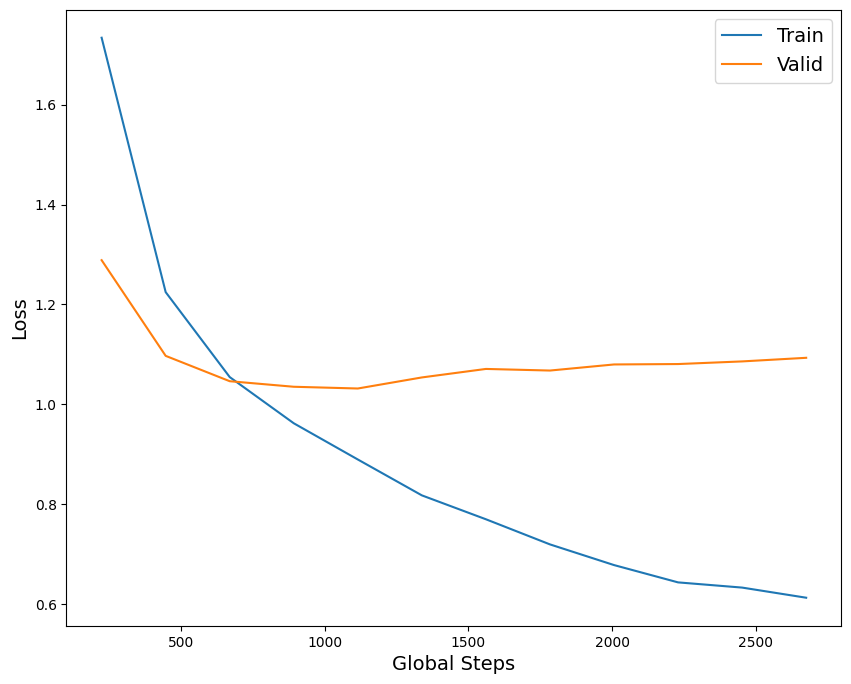

In [ ]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(metrics_path)
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show() 

In [ ]:
# Evaluation Function

def evaluate(model, testing_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
                                        
      for  _,vdata in tqdm(enumerate(testing_loader, 0)):
          vids = vdata['ids'].to(device, dtype = torch.long)
          vmask = vdata['mask'].to(device, dtype = torch.long)
          vtoken_type_ids = vdata['token_type_ids'].to(device, dtype = torch.long)
          vtargets = vdata['targets'].to(device, dtype = torch.long)

          voutputs = model(vids, vmask, vtoken_type_ids)

          y_pred.extend(torch.argmax(voutputs, axis=-1).tolist())
          y_true.extend(vtargets.tolist())
    
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1,2,3,4,5], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    
    print(y_pred)
    print(y_true)
    
    my_array = np.array([y_pred,y_true])
    df = pd.DataFrame(my_array)
    return df.T

In [ ]:
#load_checkpoint('model.pkl', model)
model  = RobertaClass(root+'/roberta_base')
model = model.to(device)

evaluate(model, valid_loader)